<a href="https://colab.research.google.com/github/YuruHuang/COVID-ZIP/blob/master/1_Bert_FineTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The purpose of this experiment is to use the state-of-art Natural Language Processing model BERT. We will fine tune the model using our custom data and see if the model performance improves. 

> We will unfreeze some of the top layers for fine-tuning 



# Data pre-processing



In [ ]:
# read in the data 
import pandas as pd
from sklearn.model_selection import train_test_split
justeat_menu = pd.read_csv('JustEat_extracted_211021.csv')
justeat_menu.head()

,Restaurant ID,Desserts,Vegetables,Salads,Chips,Water,Milk,Special Offers,rest_name,n_reviews,average_review,item_price_mean,item_price_median,n_items,url,cuisine,address,postcode,postcode_district,specialOffers,chips,salads,predict,rating2,review
0,80603,0,5,2,11,1,0,5,Pasha Kebabs & Pizzas,View 551 reviews,5.06 stars out of 6.,6.037634,7.000,93,URL,"Kebab,Pizza,Halal","25 Windmill Brae, Aberdeen, AB11 6HU",AB11 6HU,AB11,5,11,2,5.504342,1,551.0
1,71703,7,10,2,14,0,0,4,Paco's Tacos,View 2314 reviews,4.65 stars out of 6.,5.431358,4.450,162,URL,"Mexican,American","42-44 Market Street, Aberdeenshire, AB11 5PL",AB11 5PL,AB11,4,14,2,5.010865,0,2314.0
2,6885,0,16,12,1,0,0,2,Dil Se,View 1392 reviews,5.19 stars out of 6.,7.473418,8.225,158,URL,"Indian,Curry","Unit 8, The Green Berrymuir Road, Portlethen, ...",AB12 4UN,AB12,2,1,12,9.355489,4,1392.0
3,122605,5,10,6,44,0,0,1,Mannofield Pizza Grill and Kebab,View 386 reviews,5.16 stars out of 6.,8.069737,7.700,152,URL,"Pizza,Kebab","483a Great Western Road, Aberdeen, AB10 6NN",AB10 6NN,AB10,1,15,6,5.642945,1,386.0
4,44832,0,16,2,1,0,0,2,Lasan Healthy Indian Brasserie,View 595 reviews,5.04 stars out of 6.,6.877143,4.500,105,URL,"Indian,Healthy","Unit 2 Westhill Drive, Westhill, Aberdeenshire...",AB32 6FS,AB32,2,1,2,8.357649,3,595.0


BERT on tensorflow hub has a matching preprocessing model! No text cleaning processing needed. However, there are restaurants with duplicated names. For those restaurants with exactly the same name, we will calculate the **average menu healthiness** for them. 

In [ ]:
# Examples of restaurants with the same name 
counts = justeat_menu.groupby('rest_name').size().reset_index(name='counts')
counts[counts.counts>10].head()

,rest_name,counts
1024,Ali Baba,11
1742,Aroma,11
3176,Bella Pizza,21
3294,Bengal Spice,27
3402,Best Kebab,23


In [ ]:
# calculate means
justeat_df = justeat_menu[['rest_name','predict']].groupby('rest_name').mean().reset_index()
justeat_df[3990:4000]

,rest_name,predict
3990,Blue Circle Fish Bar,5.489235
3991,Blue Cobra,9.346789
3992,Blue Coral,6.626736
3993,Blue Crown Takeaway,5.729776
3994,Blue Diamond Chinese Restaurant,6.941602
3995,Blue Dolphin,5.538320
3996,Blue Dragon,5.072141
3997,Blue Elephant,7.572564
3998,Blue Elephant Aberdeen,8.035936
3999,Blue Eye Turkish Grill House,7.620525


Train test split time! 🎨

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(justeat_df.rest_name, justeat_df.predict, test_size=0.1, random_state=42)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=68)

# Model 0 BERT (frozen)



In [ ]:
#!pip install tensorflow-text
import tensorflow_text as text
import tensorflow_hub as hub
import tensorflow as tf

preprocessor = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

In [ ]:
# An example of how the preprocessor converts a restaurant name to a tensor input for BERT model 
preprocessor(['Yuru Chinese Takeaway'])

{'input_mask': <tf.Tensor: shape=(1, 128), dtype=int32, numpy=
 array([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
       dtype=int32)>,
 'input_type_ids': <tf.Tensor: shape=(1, 128), dtype=int32, numpy=
 array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
def build_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(preprocessor, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4", name = 'BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(64, activation='relu')(net)
  net = tf.keras.layers.Dense(1, activation=None, name='regression_output')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
model_0 =  build_model()

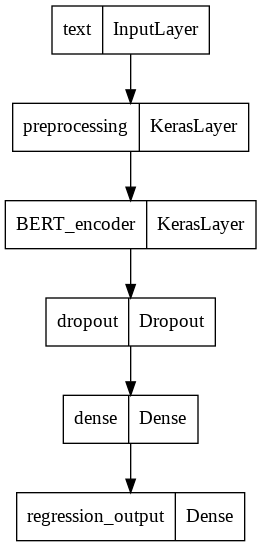

In [ ]:
tf.keras.utils.plot_model(model_0)

In [ ]:
model_0.compile(loss="mean_squared_error",
                optimizer=tf.keras.optimizers.Adam(),
                metrics = ['mae','mean_absolute_percentage_error'])

In [ ]:
model_0_history = model_0.fit(X_train, y_train, epochs=20, validation_data = (X_val, y_val))

Epoch 1/20
1187/1187 [==============================] - 828s 694ms/step - loss: 2.0779 - mae: 1.0966 - mean_absolute_percentage_error: 24.1185 - val_loss: 1.8886 - val_mae: 1.0514 - val_mean_absolute_percentage_error: 22.1452
Epoch 2/20
1187/1187 [==============================] - 825s 695ms/step - loss: 1.8743 - mae: 1.0493 - mean_absolute_percentage_error: 23.3046 - val_loss: 1.8569 - val_mae: 1.0323 - val_mean_absolute_percentage_error: 22.2868
Epoch 3/20
1187/1187 [==============================] - 821s 691ms/step - loss: 1.8289 - mae: 1.0334 - mean_absolute_percentage_error: 23.0053 - val_loss: 1.7735 - val_mae: 1.0083 - val_mean_absolute_percentage_error: 21.9784
Epoch 4/20
1187/1187 [==============================] - 821s 692ms/step - loss: 1.8187 - mae: 1.0317 - mean_absolute_percentage_error: 22.8479 - val_loss: 1.7613 - val_mae: 1.0036 - val_mean_absolute_percentage_error: 21.9619
Epoch 5/20
1187/1187 [==============================] - 817s 689ms/step - loss: 1.8073 - mae: 1.

# Model 1 BERT Fine tuning 

Bert Base model uses 12 layers of transformers block 